In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
plt.style.use('fivethirtyeight')
import os
import warnings 
warnings.filterwarnings('ignore')

In [2]:
class FinancialAnalysis:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.csv_files = data_folder + '/csv_files'
    def load_data(self):
        df = {}
        tickers = ['AAPL', 'ETH-USD', 'PFE', 'NVDA', 'AMD', 'BTC-USD']
        for file in os.listdir(self.csv_files):
            for i in range(len(tickers)):
                if file == tickers[i] + '.csv':
                    df[i] = pd.read_csv(self.csv_files + '/'+file, index_col = ['Date'])
        for i in range(len(df)):
            df[i].index = pd.to_datetime(df[i].index, infer_datetime_format= True)
        
        self.data = df
    def basic_technical_analysis(self, data):
        data.ta.percent_return(cumulative = False, append = True)
    def macd_strategy(self, data, risk):

        MACD_Buy=[]
        MACD_Sell=[]
        MACD_color = []
        
        position=False
        macd = ta.macd(data['Close'])
        data = pd.concat([data, macd], axis=1).reindex(data.index)
        
        for i in range(0, len(data)):
            if data['MACD_12_26_9'][i] > data['MACDs_12_26_9'][i] :
                MACD_Sell.append(np.nan)
                if position == False:
                    MACD_Buy.append(data['Adj Close'][i])
                    position= True
                else:
                    MACD_Buy.append(np.nan)
            elif data['MACD_12_26_9'][i] < data['MACDs_12_26_9'][i] :
                MACD_Buy.append(np.nan)
                if position == True:
                    MACD_Sell.append(data['Adj Close'][i])
                    position=False
                else:
                    MACD_Sell.append(np.nan)
            
            elif position == True and data['Adj Close'][i] < MACD_Buy[-1] * (1 - risk):
                MACD_Sell.append(data["Adj Close"][i])
                MACD_Buy.append(np.nan)
                position = False
            elif position == True and data['Adj Close'][i] < data['Adj Close'][i - 1] * (1 - risk):
                MACD_Sell.append(data["Adj Close"][i])
                MACD_Buy.append(np.nan)
                position = False
            else:
                MACD_Buy.append(np.nan)
                MACD_Sell.append(np.nan)
            if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i - 1]:
                    MACD_color.append(True)
            else:
                MACD_color.append(False)
        a = self.MACD_color(macd)
        # plt.plot(macd['MACD_12_26_9'], color = 'blue', label = 'MACD')
        # plt.plot(macd['MACDh_12_26_9'], label = 'Volume')
        color_ = ''
        for i in a:
            if i == True:
                color_ = 'g'
            else:
                color_ = 'r'
                
        plt.bar(self.data[0].index, macd['MACDh_12_26_9'], color = color_)
        plt.show()
                
        return MACD_Buy, MACD_Sell, MACD_color
    def bb_strategy(self, data):
        bbBuy = []
        bbSell = []
        position = False
        bb = ta.bbands(data['Adj Close'], length=20,std=2)
        data = pd.concat([data, bb], axis=1).reindex(data.index)

        for i in range(len(data)):
            if data['Adj Close'][i] < data['BBL_20_2.0'][i]:
                if position == False:
                    bbBuy.append(data['Adj Close'][i])
                    bbSell.append(np.nan)
                    position = True
                else:
                    bbBuy.append(np.nan)
                    bbSell.append(np.nan)
            elif data['Adj Close'][i] > data['BBU_20_2.0'][i]:
                if position == True:
                    bbBuy.append(np.nan)
                    bbSell.append(data['Adj Close'][i])
                    position = False
                else:
                    bbBuy.append(np.nan)
                    bbSell.append(np.nan)
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)  
          
        return bbBuy, bbSell
        
    
    def sma_strategy(self, data):
        data['SMA 30'] = ta.sma(data['Close'],30)
        data['SMA 100'] = ta.sma(data['Close'],100)
        signalBuy = []
        signalSell = []
        position = False
        for i in range(len(data)):
            if data['SMA 30'][i] > data['SMA 100'][i]:
                if position == False:
                    signalBuy.append(data['Adj Close'][i])
                    signalSell.append(np.nan)
                    position = True
                else:
                    signalBuy.append(np.nan)
                    signalSell.append(np.nan)
            elif data['SMA 30'][i] < data['SMA 100'][i]:
                if position == True:
                    signalBuy.append(np.nan)
                    signalSell.append(data['Adj Close'][i])
                    position = False
                else:
                    signalBuy.append(np.nan)
                    signalSell.append(np.nan)
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        return pd.Series([signalBuy, signalSell])
    def strategy_plotter(self, data, label_, strategy):
        
        
        if strategy == 'SMA':
            fig, ax = plt.subplots(figsize=(20,12))
            ax.plot(data['Adj Close'] , label = label_ ,linewidth=0.5, color='blue', alpha = 0.9)
            ax.plot(data['SMA 30'], label = 'SMA30', alpha = 0.85)
            ax.plot(data['SMA 100'], label = 'SMA100' , alpha = 0.85)
            ax.scatter(data.index , data['SMA_buy'] , label = 'Buy' , marker = '^', color = 'green',alpha =1,linewidths=3 )
            ax.scatter(data.index , data['SMA_sell'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1, linewidths=3 )
            ax.set_title(label_ +' SMA Cross Strategy', fontsize = 10, color = 'black')
            ax.plot()
            ax.set_xlabel('Date',fontsize=18)
            ax.set_ylabel('Close Price' , fontsize=18)
            legend = ax.legend()
            ax.grid()
            plt.tight_layout()
            plt.show()
        elif strategy == 'MACD':
            fig, ax1 = plt.subplots(figsize=(20,12))
            ax1.set_ylabel('Close Price')
            ax1.plot('Adj Close',data=data, label='Close Price', linewidth=0.5, color='blue')
            ax1.scatter(data.index, data['MACD_buy'], color='green', marker='^', alpha=1, linewidth = 1.5)
            ax1.scatter(data.index, data['MACD_sell'], color='red', marker='v', alpha=1, linewidth = 1.5)
            ax1.legend()
            ax1.grid()
            ax1.set_xlabel('Date', fontsize=8)
            plt.show()
        else:
            bb = ta.bbands(self.data[0]['Adj Close'], length=20,std=2)
            fig, ax1 = plt.subplots(figsize=(20,14))
            fig.suptitle('AAPL', fontsize=10, backgroundcolor='blue', color='white')
            ax1 = plt.subplot2grid((20, 14), (0, 0), rowspan=8, colspan=14)
            ax2 = plt.subplot2grid((20, 14), (10, 0), rowspan=6, colspan=14)
            ax1.set_ylabel('Price')
            ax1.plot(data['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
            ax1.scatter(data.index, data['BB_buy'], color='green', marker='^', alpha=1)
            ax1.scatter(data.index, data['BB_sell'], color='red', marker='v', alpha=1)
            ax1.legend()
            ax1.grid()
            ax1.set_xlabel('Date', fontsize=8)

            ax2.plot(bb['BBM_20_2.0'], label='Middle', color='blue', alpha=0.35) #middle band
            ax2.plot(bb['BBU_20_2.0'], label='Upper', color='green', alpha=0.35) #Upper band
            ax2.plot(bb['BBL_20_2.0'], label='Lower', color='red', alpha=0.35) #lower band
            ax2.fill_between(self.data[0].index, bb['BBL_20_2.0'], bb['BBU_20_2.0'], alpha=0.1)
            ax2.legend(loc='upper left')
            ax2.grid()
            plt.show()
            

        
    def MACD_color(self, data):
        MACD_color = []
        for i in range(0, len(data)):
            if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i - 1]:
                MACD_color.append(True)
        else:
            MACD_color.append(False)
        return pd.DataFrame([MACD_color])
    def run(self):
        self.load_data()
        for i in range(len(self.data)):
            self.basic_technical_analysis(self.data[i])
        self.data[0]['SMA_buy'], self.data[0]['SMA_sell'] = self.sma_strategy(self.data[0])
        self.strategy_plotter(self.data[0], 'AAPL', 'SMA')
        # self.data[1]['SMA_buy'], self.data[1]['SMA_sell'] = self.sma_strategy(self.data[1])
        # self.strategy_plotter(self.data[1], 'ETH-USD', 'SMA')
        self.data[0]['MACD_buy'], self.data[0]['MACD_sell'], self.data[0]['positive'] = self.macd_strategy(self.data[0], 0.025)
        self.strategy_plotter(self.data[0], 'A', 'MACD')
        self.data[0]['BB_buy'], self.data[0]['BB_sell'] = self.bb_strategy(self.data[0])
        self.strategy_plotter(self.data[0], 'A', 'BB')




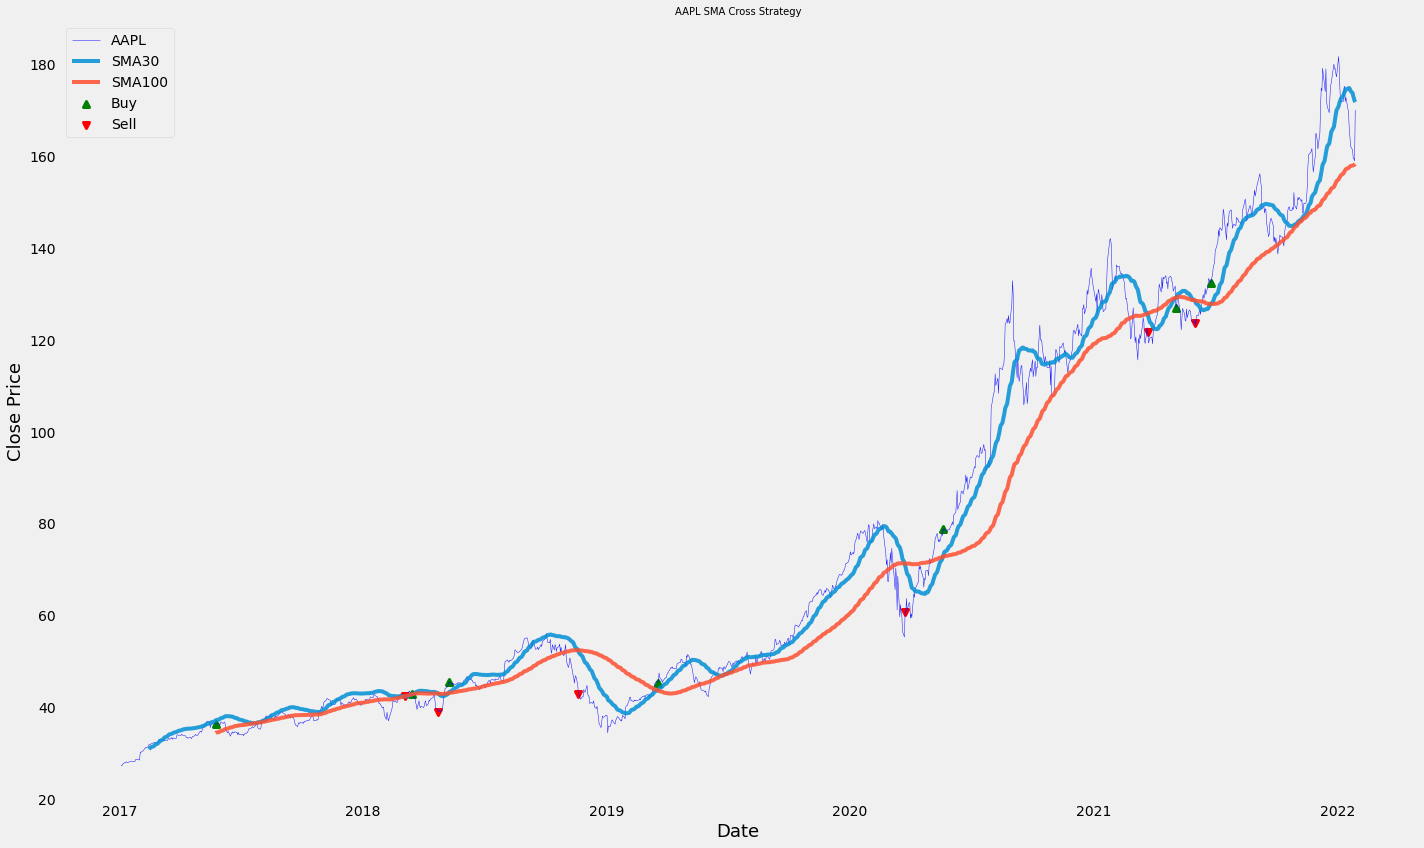

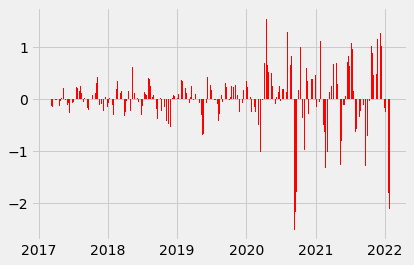

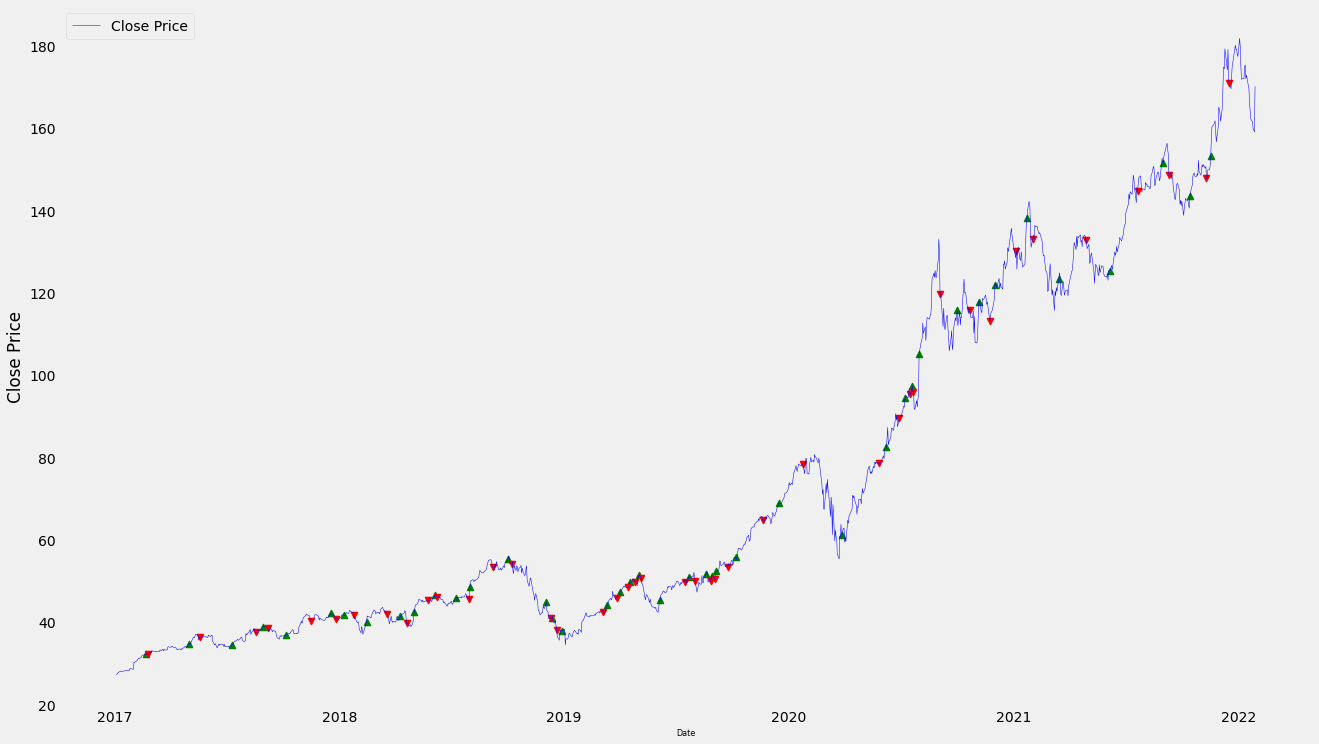

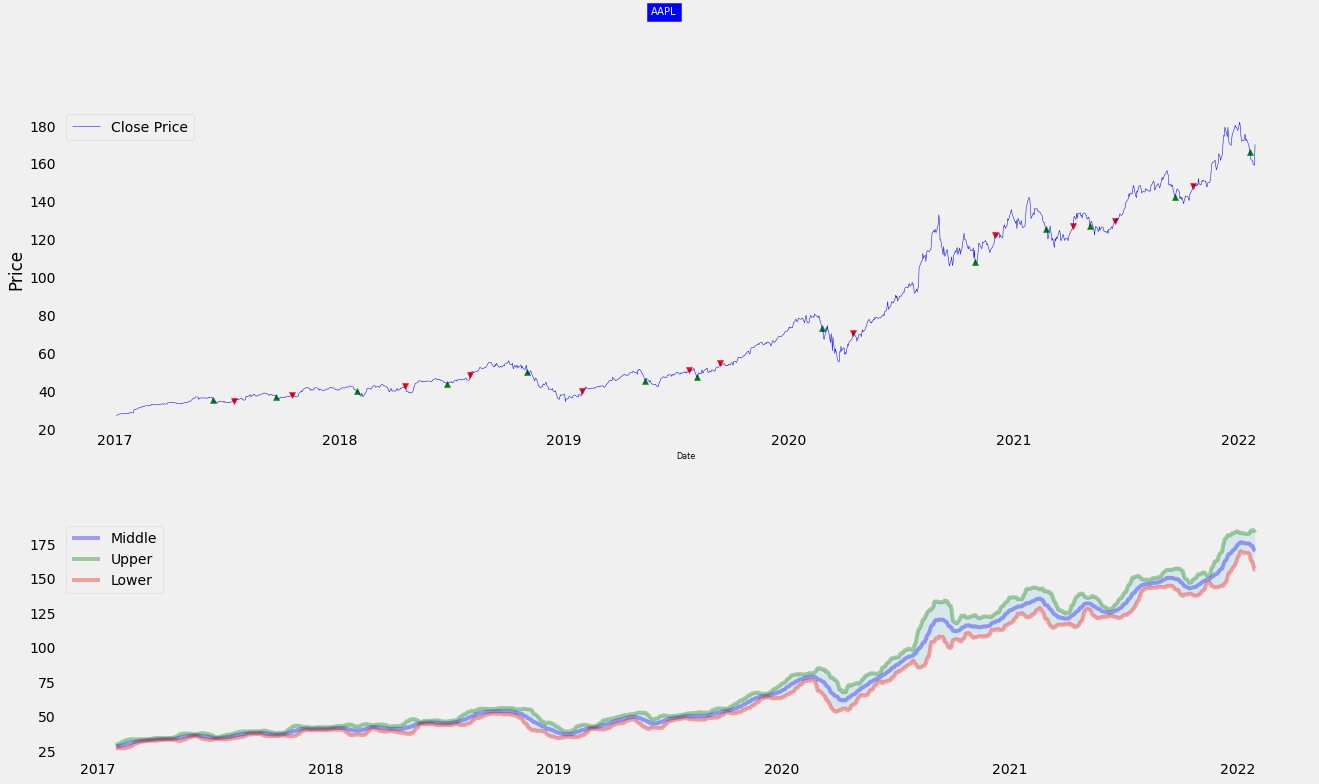

In [3]:
o = FinancialAnalysis('../data')
o.run()